# Hands-On NLP
## Class 4

<span style="color:magenta">Group Names:</span>

* Name 1
* Name 2
* Name 3

### Outline:

- Simple tokenization

- Words and indices

- Initialization

- Visualization

- Forward, cost, backward, training

- First on a sentence, then on a larger text

Main goal: understand the transformations needed to obtain vector representations

In [1]:
import doctest
import re
from collections import Counter
from datetime import datetime
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 4)

print("sklearn's version:", sklearn.__version__)    # 1.4.0
print("pandas's version:", pd.__version__)          # 2.2.0

sklearn's version: 1.6.1
pandas's version: 2.2.3


In [3]:
%config InlineBackend.figure_format="retina"  # For high DPI display

In [4]:
doctest.testmod(optionflags=doctest.ELLIPSIS)

TestResults(failed=0, attempted=0)

In [5]:
EPS = np.finfo(float).eps

TOY_CORPUS = """What is a word embedding?
A word vector (or embeddings) is a dense representation,
which captures semantic relationships between words."""

In [6]:
def tokenize(text, pattern=r"\w+"):
    """Tokenize a text into a list of tokens.
    >>> tokenize("Let's do hands-on Natural Language Processing!")
    ['let', 's', 'do', 'hands', 'on', 'natural', 'language', 'processing']
    """
    return re.findall(pattern, text.lower())

In [7]:
pprint(tokenize(TOY_CORPUS), compact=True)

['what', 'is', 'a', 'word', 'embedding', 'a', 'word', 'vector', 'or',
 'embeddings', 'is', 'a', 'dense', 'representation', 'which', 'captures',
 'semantic', 'relationships', 'between', 'words']


In [8]:
def build_vocab(tokens, show_df=False):
    """
    Builds a vocabulary from a list of tokens and returns the vocabulary list and a dictionary mapping tokens to their indices.

    Parameters:
    tokens (list of str): A list of tokens (words) from which to build the vocabulary.
    show_df (bool): If True, display the DataFrame of token counts.

    Returns:
    vocab (list of str): A list of unique tokens sorted by their frequency in descending order.
    voc2idx (dict): A dictionary mapping each token to its index in the vocabulary list.

    """
    df = pd.DataFrame(Counter(tokens).most_common(), columns=["token", "count"])
    if show_df:
        display(df)

    vocab = df.token.to_list()
    voc2idx = {word: idx for idx, word in enumerate(vocab)}

    return vocab, voc2idx

### CBOW

For the calculation of the word2vec we also have the CBOW (continuous bag of words) method as an alternative to Skipgram.
In CBOW, we try to predict the central word from the whole context of the central word.
Our xs, ys training data have fewer inputs, only as many as the text has words, but are richer.
For prediction, we sum the context vectors to predict the center.

In [9]:
def generate_cbow_data(tokens, window_size):
    """
    Create the pairs xs, ys for the training:
    xs and ys have the same length (index of the central word,
    index of an observed word of the context of the central word)

    generate_cbow_data(
       ['let', 's', 'do', 'hands', 'on', 'natural', 'language', 'processing'],
       window_size=2,
    )
    ([[1, 2],
      [0, 2, 3],
      [0, 1, 3, 4],
      [1, 2, 4, 5],
      [2, 3, 5, 6],
      [3, 4, 6, 7],
      [4, 5, 7],
      [5, 6]],
     [0, 1, 2, 3, 4, 5, 6, 7])
    """
    tokens_n = len(tokens)
    _, voc2idx = build_vocab(tokens)
    xs, ys = [], []

    for i in range(tokens_n):
        context = []
        for j in range(max(0, i - window_size), min(tokens_n, i + window_size + 1)):
            if j != i:
                context.append(voc2idx[tokens[j]])
        xs.append(context)
        ys.append(voc2idx[tokens[i]])

    return xs, ys

### Skipgram

In [10]:
def generate_skip_data(tokens, window_size):
    """
    Create the pairs xs, ys for the training:
    xs and ys have the same length (index of the central word,
    index of an observed word of the context of the central word)

    >>> tokens = ['let', 's', 'do', 'hands', 'on', 'natural', 'language', 'processing']
    >>> xs, ys = generate_skip_data(tokens, window_size=2)
    >>> print(len(xs[0]), len(ys[0]))
    26 26
    >>> print(xs)
    [[0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7]]
    >>> print(ys)
    [[1, 2, 0, 2, 3, 0, 1, 3, 4, 1, 2, 4, 5, 2, 3, 5, 6, 3, 4, 6, 7, 4, 5, 7, 5, 6]]
    """
    tokens_n = len(tokens)
    _, voc2idx = build_vocab(tokens)
    xs, ys = [], []

    for i in range(tokens_n):
        for j in range(max(0, i - window_size), min(tokens_n, i + window_size + 1)):
            if j != i:
                xs.append(voc2idx[tokens[i]])
                ys.append(voc2idx[tokens[j]])

    return [xs], [ys]

In [11]:
# let's test these functions:
tokens = tokenize(TOY_CORPUS)
pprint(tokens, compact=True)

vocab, voc2idx = build_vocab(tokens, show_df=True)

xs, ys = generate_cbow_data(tokens, 3)
print(len(xs), len(ys))
xs

['what', 'is', 'a', 'word', 'embedding', 'a', 'word', 'vector', 'or',
 'embeddings', 'is', 'a', 'dense', 'representation', 'which', 'captures',
 'semantic', 'relationships', 'between', 'words']


,token,count
0,a,3
1,is,2
2,word,2
3,what,1
4,embedding,1
5,vector,1
6,or,1
7,embeddings,1
8,dense,1
9,representation,1


20 20


[[1, 0, 2],
 [3, 0, 2, 4],
 [3, 1, 2, 4, 0],
 [3, 1, 0, 4, 0, 2],
 [1, 0, 2, 0, 2, 5],
 [0, 2, 4, 2, 5, 6],
 [2, 4, 0, 5, 6, 7],
 [4, 0, 2, 6, 7, 1],
 [0, 2, 5, 7, 1, 0],
 [2, 5, 6, 1, 0, 8],
 [5, 6, 7, 0, 8, 9],
 [6, 7, 1, 8, 9, 10],
 [7, 1, 0, 9, 10, 11],
 [1, 0, 8, 10, 11, 12],
 [0, 8, 9, 11, 12, 13],
 [8, 9, 10, 12, 13, 14],
 [9, 10, 11, 13, 14, 15],
 [10, 11, 12, 14, 15],
 [11, 12, 13, 15],
 [12, 13, 14]]

In [12]:
ys

[3, 1, 0, 2, 4, 0, 2, 5, 6, 7, 1, 0, 8, 9, 10, 11, 12, 13, 14, 15]

In [13]:
xs, ys = generate_skip_data(tokens, 3)
xs, ys = np.array(xs), np.array(ys)
print(xs.shape, ys.shape)
print(xs)

(1, 108) (1, 108)
[[ 3  3  3  1  1  1  1  0  0  0  0  0  2  2  2  2  2  2  4  4  4  4  4  4
   0  0  0  0  0  0  2  2  2  2  2  2  5  5  5  5  5  5  6  6  6  6  6  6
   7  7  7  7  7  7  1  1  1  1  1  1  0  0  0  0  0  0  8  8  8  8  8  8
   9  9  9  9  9  9 10 10 10 10 10 10 11 11 11 11 11 11 12 12 12 12 12 12
  13 13 13 13 13 14 14 14 14 15 15 15]]


In [14]:
print(ys)

[[ 1  0  2  3  0  2  4  3  1  2  4  0  3  1  0  4  0  2  1  0  2  0  2  5
   0  2  4  2  5  6  2  4  0  5  6  7  4  0  2  6  7  1  0  2  5  7  1  0
   2  5  6  1  0  8  5  6  7  0  8  9  6  7  1  8  9 10  7  1  0  9 10 11
   1  0  8 10 11 12  0  8  9 11 12 13  8  9 10 12 13 14  9 10 11 13 14 15
  10 11 12 14 15 11 12 13 15 12 13 14]]


In [15]:
vocab, voc2idx = build_vocab(tokens)
vocab_size = len(vocab)
ys = np.array(ys)
m = np.array(ys).shape[1]

# ys in one-hot encoding:
one_hot_ys = np.zeros((vocab_size, m))
one_hot_ys[ys.flatten(), np.arange(m)] = 1  # important to understand for later!
one_hot_ys.shape  # can you explain the shape?

(16, 108)

### 🚧 TODO:

*   Explain why there are three 3's, four 1's... in `xs`

*   Explain why there are more 0's than, e.g., 3's in `ys`

In [16]:
def initialize_embeddings(vocab_size, emb_size, seed=None):
    """
    Initializes a matrix of word embeddings with random values.

    Parameters:
    vocab_size (int): Vocabulary size of your corpus or training data.
    emb_size (int): Word embedding size (dimensions to represent each word).

    Returns:
    np.ndarray: A matrix of shape (vocab_size, emb_size) where each row corresponds to the embedding of a word.

    🚧 TODO: complete the "_____"
    returns a matrix of shape: (vocab_size, emb_size)
    each row corresponds to the embedding of a word
    end TODO
    """
    rng = np.random.default_rng(seed)
    return rng.normal(loc=0, scale=0.01, size=(vocab_size, emb_size))

Check out the parameters in the doc: [np.random.Generator.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal).

In [17]:
def initialize_dense(input_size, output_size, seed=None):
    """
    Initializes a weight matrix for a dense (fully connected) layer with random values.

    Parameters:
    input_size (int): Size of the input to the dense layer.
    output_size (int): Size of the output of the dense layer.

    Returns:
    np.ndarray: A matrix of shape (output_size, input_size) where each row corresponds to the weights for one output neuron.

    🚧 TODO: complete the "______"
    returns a matrix of shape : (output_size, input_size)
    each row corresponds to the weights for one output neuron
    end TODO
    """
    rng = np.random.default_rng(seed)
    return rng.normal(loc=0, scale=0.01, size=(output_size, input_size))

In [18]:
def initialize_parameters(vocab_size, emb_size, seed=None):
    """
    Initialize all the training parameters
    """
    embs = initialize_embeddings(vocab_size, emb_size, seed)
    ws = initialize_dense(emb_size, vocab_size, seed)

    parameters = {}
    parameters["EMBS"] = embs
    parameters["W"] = ws

    return parameters

In [19]:
# for example an embedding of dimension 5
parameters = initialize_parameters(len(vocab), emb_size=5, seed=42)

In [20]:
print(parameters["EMBS"].shape, parameters["W"].shape)

(16, 5) (16, 5)


In [21]:
# We can multiply them:
(parameters["EMBS"].T @ parameters["W"]).shape

(5, 5)

In [22]:
def plot_embedding(vs, indices, vocab):
    pca = PCA(n_components=2)
    data = pca.fit_transform(vs).transpose()
    xs, ys = data[0], data[1]
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.scatter(xs, ys, c="green")
    for i, idx in enumerate(indices):
        ax.annotate(
            vocab[idx], (xs[i], ys[i]), xytext=(5, 5), textcoords="offset points"
        )
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("2 dimensions of the word embeddings")
    plt.show()

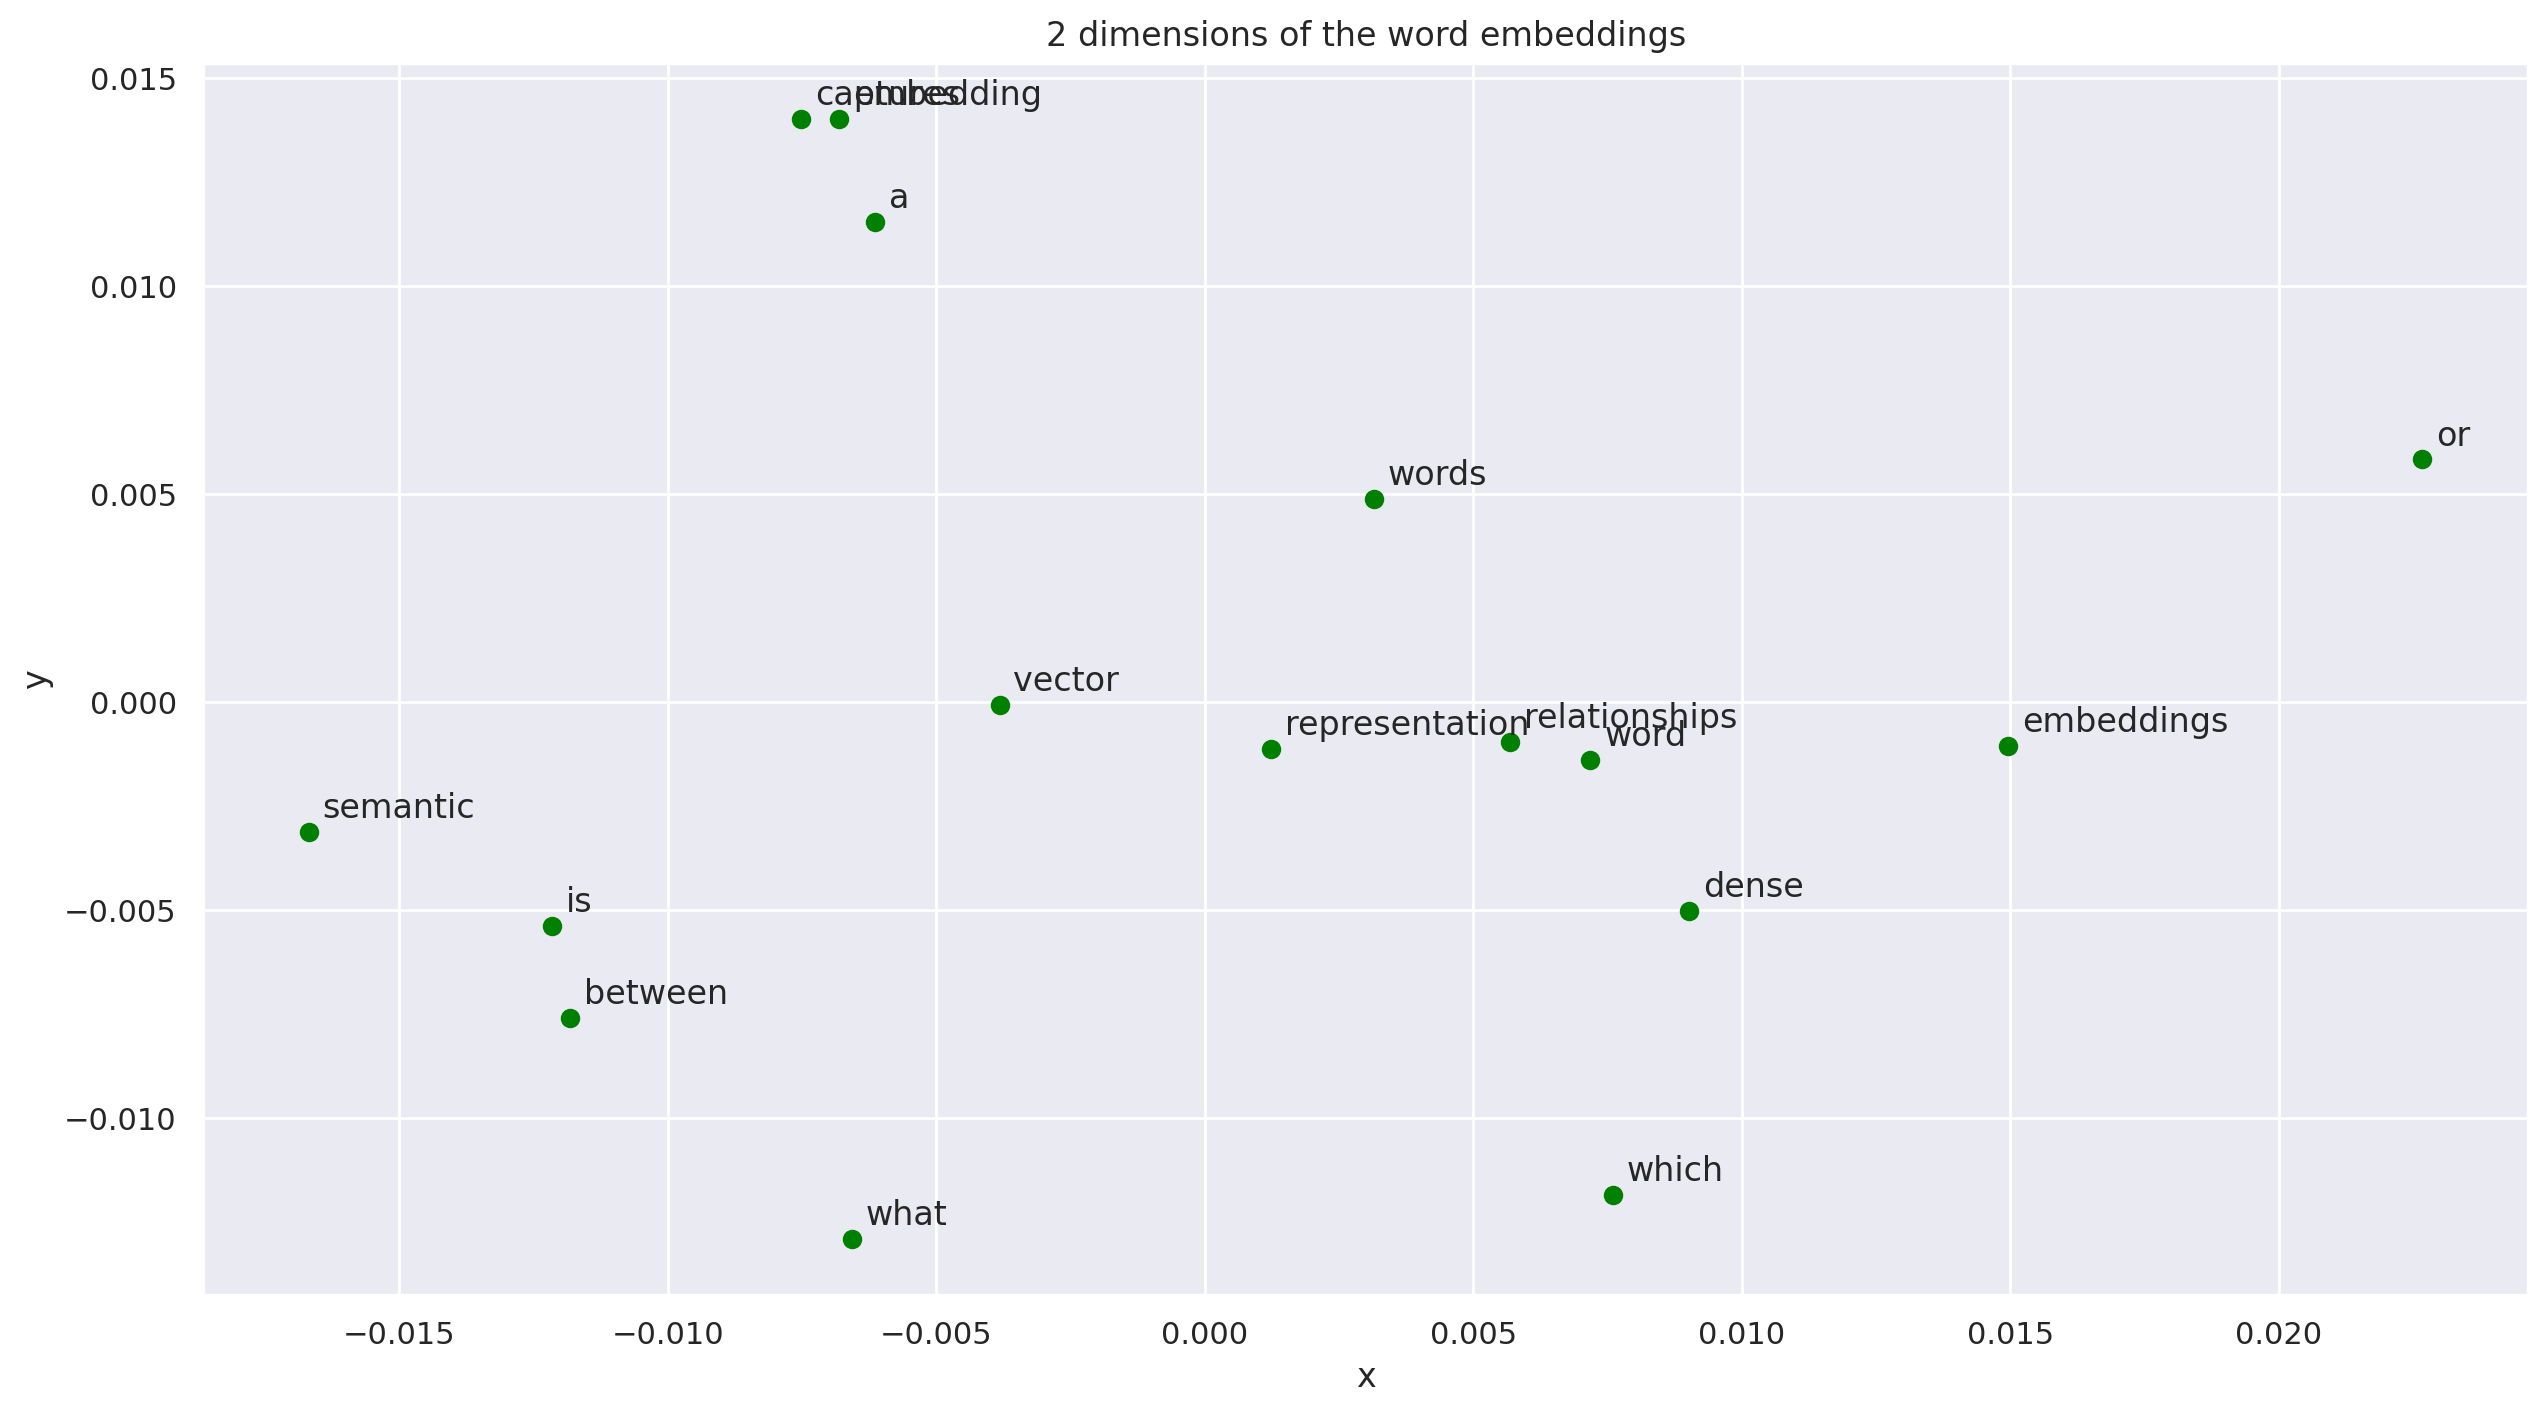

In [23]:
# plotting all the words that have just been initialized:
# print(parameters["emb"].shape)
plot_embedding(parameters["EMBS"], voc2idx.values(), vocab)

In [25]:
def ind_to_word_embs(inds, parameters):
    """
    Converts indices to word embeddings.

    Parameters:
    inds (numpy array): A numpy array of shape (1, m) containing the indices of the words.
    parameters (dict): A dictionary containing the weights to be trained, including the embedding matrix "EMBS".

    Returns:
    np.ndarray: A matrix of word vectors as columns with shape (embedding_dim, m).

    🚧 TODO: complete:
    returns a matrix of word vectors as columns with shape (embedding_dim, m)
    end TODO

    """
    m = inds.shape[1]
    embs = parameters["EMBS"]

    # Select the rows of the embedding matrix corresponding to the indices
    #     flatten() -> 1D array (as many elements as indices)
    w_embs = embs[inds.flatten(), :].T

    assert w_embs.shape == (embs.shape[1], m)

    return w_embs

In [26]:
def linear_dense(w_embs, parameters):
    """
    Applies a linear transformation (dense layer) to the word embeddings.

    Parameters:
    w_embs (numpy array): A numpy array of shape (emb_size, m) containing the word embeddings.
    parameters (dict): A dictionary containing the weights to be trained, including the weight matrix "W".

    Returns:
    tuple: A tuple containing:
        - ws (numpy array): The matrix of weights of the dense layer.
        - zs (numpy array): The output matrix of the dense layer.

    🚧 TODO: complete :
    zs is of shape: (output_size, m)
    end TODO

    """
    m = w_embs.shape[1]
    ws = parameters["W"]
    zs = np.dot(ws, w_embs)

    assert zs.shape == (ws.shape[0], m)

    return ws, zs

In [27]:
def softmax(zs):
    """
    zs: output out of the dense layer.
        shape: (vocab_size, m = number of input vectors (tokens to update))
    """
    softmax_out = np.divide(
        np.exp(zs), np.sum(np.exp(zs), axis=0, keepdims=True) + EPS
    )
    assert softmax_out.shape == zs.shape

    return softmax_out

In [28]:
def forward_propagation(inds, parameters):
    w_embs = ind_to_word_embs(inds, parameters)
    ws, zs = linear_dense(w_embs, parameters)
    softmax_out = softmax(zs)

    caches = {}
    caches["inds"] = inds
    caches["w_embs"] = w_embs
    caches["W"] = ws
    caches["Z"] = zs
    return softmax_out, caches

In [29]:
def cross_entropy(softmax_out, ys):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m=batch_size)
    ys: ground truth: indices à prédire. shape: (1, m)
    """
    m = softmax_out.shape[1]

    cost = -(1 / m) * np.sum(
        np.log(softmax_out[ys.flatten(), np.arange(ys.shape[1])] + EPS)
    )
    return cost

🚧 TODO, read this carrefully:

* From the softmax out, I select the lines corresponding to the predicted tokens

* It gives me the probabilities, I take the log, and I average it

* If the prediction was perfect, the probability would be 1, the log is 0 --> zero cost

* If not, I have a proba smaller than 1, I take the average of these probas logs (which are all negative)

* With the "$-$" it becomes positive, so it is a measure of the error of the prediction

* Note that `ys` can contain several times the same index to predict. It is counted as many times as it should be predicted.

$$\frac{dL}{dZ} = softmax\_out - ys$$

$$\frac{dL}{dW} = \frac{dL}{dZ}\times\frac{dZ}{dW}= \frac{dL}{dZ}\times w\_embs.T$$

$$
\frac{dL}{d w\_embs} = \frac{dL}{dZ}\times\frac{dZ}{d w\_embs}
    = \frac{dL}{dZ} \times W.T
$$

In [30]:
def softmax_backward(ys, softmax_out):
    """
    ys: labels of training data. shape: (1, m=batch_size)
    softmax_out: output out of softmax. shape: (vocab_size, m=batch_size)
    """
    m = ys.shape[1]

    # we compute the difference between the prediction and the ground truth (ys)
    # if the prediction was perfect, the dl_dz becomes 0
    # we only touch the lines to predict
    # if the token is not to be predicted, we do not touch the line
    softmax_out[ys.flatten(), np.arange(m)] -= 1.0
    dl_dz = softmax_out

    assert dl_dz.shape == softmax_out.shape
    return dl_dz

In [31]:
def dense_backward(dl_dz, caches):
    """
    dl_dz: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    dl_dz has negative values where something needs to be changed.
    the more negative they are, the worse it is.
    """
    ws = caches["W"]
    w_embs = caches["w_embs"]
    m = w_embs.shape[1]

    # we multiply where we need to change something:
    # dl_dz.shape = (vocab_size, m)
    dl_dw = (1 / m) * np.dot(dl_dz, w_embs.T)
    dl_dw_embs = np.dot(ws.T, dl_dz)

    assert ws.shape == dl_dw.shape
    assert w_embs.shape == dl_dw_embs.shape

    return dl_dw, dl_dw_embs

In [32]:
def backward_propagation(ys, softmax_out, caches):
    dl_dz = softmax_backward(ys, softmax_out)
    dl_dw, dl_dw_embs = dense_backward(dl_dz, caches)

    gradients = dict()
    gradients["dL_dZ"] = dl_dz
    gradients["dL_dW"] = dl_dw
    gradients["dL_dw_embs"] = dl_dw_embs

    return gradients

In [33]:
def update_parameters(parameters, caches, gradients, learning_rate):
    """
    here we update the embedding
    """
    vocab_size, emb_size = parameters["EMBS"].shape
    inds = caches["inds"]
    embs = parameters["EMBS"]
    dl_dw_embs = gradients["dL_dw_embs"]
    m = inds.shape[-1]

    # note that only the lines corresponding to the central words are modified
    embs[inds.flatten(), :] -= dl_dw_embs.T * learning_rate

    parameters["W"] -= learning_rate * gradients["dL_dW"]

In [35]:
def skipgram_model_training(
    xs,
    ys,
    vocab_size,
    emb_size,
    learning_rate,
    epochs,
    batch_size=256,
    parameters=None,
    print_cost=False,
    plot_cost=True,
):
    costs = []
    m = xs.shape[1]

    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)

    # for the moment these three variables are not used
    # 🚧 TODO: use these variables to keep the best model at the end
    best_epoch = 0
    min_epoch_cost = float("inf")
    parameters["best_embeddings"] = parameters["EMBS"]

    begin_time = datetime.now()
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            batch_xs = xs[:, i : i + batch_size]
            batch_ys = ys[:, i : i + batch_size]

            softmax_out, caches = forward_propagation(batch_xs, parameters)
            cost = cross_entropy(softmax_out, batch_ys)
            gradients = backward_propagation(batch_ys, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            epoch_cost += cost

        costs.append(epoch_cost)
        # 🚧 TODO: add here the code to keep the best_embeddings
        if epoch_cost < min_epoch_cost:
            min_epoch_cost = epoch_cost
            best_epoch = epoch
            parameters["best_embeddings"] = parameters["EMBS"].copy()
        # end TODO

        if print_cost and epoch % 200 == 0:
            print(f"Cost after epoch {epoch:4d}: {epoch_cost:.4f}")
        if epoch % (epochs // 100) == 0:
            learning_rate *= 0.98
    end_time = datetime.now()
    print(f"training time: {end_time - begin_time}")
    print(
        f"🚧 TODO I've kept the embedding of epoch {best_epoch} "
        f"with cost {min_epoch_cost:.4f}."
    )
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel("# of epochs")
        plt.ylabel("cost")
    return parameters

In [36]:
print(ys.shape, xs.shape, one_hot_ys.shape)

(1, 108) (1, 108) (16, 108)


Cost after epoch    0: 2.7726
Cost after epoch  200: 2.7434
Cost after epoch  400: 2.5521
Cost after epoch  600: 2.4268
Cost after epoch  800: 2.3135
Cost after epoch 1000: 2.2638
Cost after epoch 1200: 2.2433
Cost after epoch 1400: 2.2334
Cost after epoch 1600: 2.2277
Cost after epoch 1800: 2.2235
Cost after epoch 2000: 2.2201
Cost after epoch 2200: 2.2174
Cost after epoch 2400: 2.2154
Cost after epoch 2600: 2.2140
Cost after epoch 2800: 2.2132
training time: 0:00:00.333371
🚧 TODO I've kept the embedding of epoch 2999 with cost 2.2128.


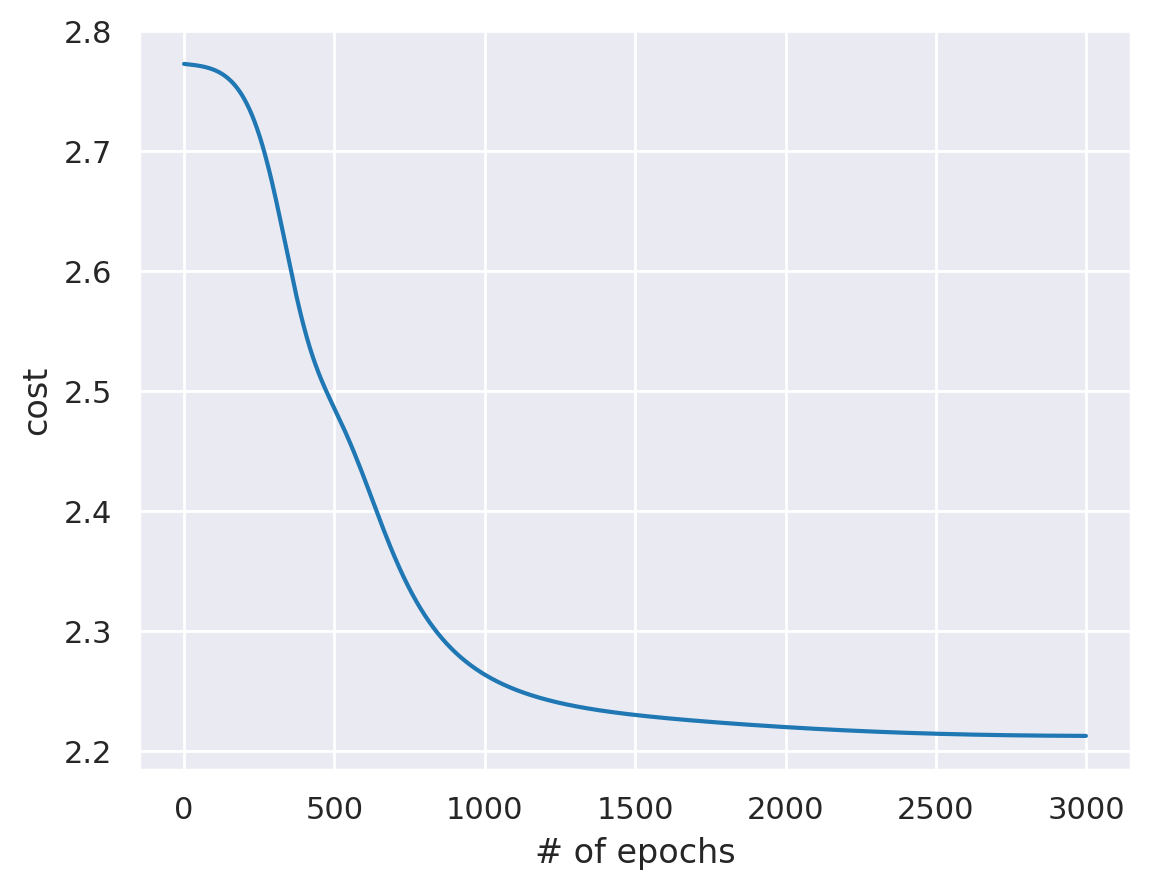

In [37]:
parameters = skipgram_model_training(
    xs,
    ys,
    vocab_size,
    emb_size=50,
    learning_rate=0.05,
    epochs=3000,
    batch_size=128,
    parameters=None,
    print_cost=True,
)
# test with a small batch_size to see....

####  🚧 TODO:

- Keep the best model

- Visualize also the best model

### First intrinsic evaluation

- Let's take the indices of all the words

- Send them into the grinder

- See if the system can predict the words that were close as the most probable

In [38]:
test_xs = np.arange(vocab_size)
print(test_xs, test_xs.shape)
test_xs = np.expand_dims(test_xs, axis=0)
print(test_xs, test_xs.shape)

# 🚧 TODO: complete

# send test_xs to the forward_propagation
softmax_test, _ = forward_propagation(test_xs, parameters)

# find the 5 most likely indices:
top_sorted_inds = np.argsort(softmax_test, axis=0)[-5:][::-1]

# end TODO

top_sorted_inds

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] (16,)
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]] (1, 16)


array([[10,  9,  7,  2,  2,  1,  0,  8, 11, 12, 12, 14, 15, 15, 15, 14],
       [ 9,  0,  4,  1,  5,  7,  2,  5, 10,  8, 13, 12, 11, 11, 11, 13],
       [ 1,  8,  0,  0,  1,  0,  1,  6,  0, 11,  9, 13, 14, 14, 14, 12],
       [ 4,  3,  2,  7,  0,  2,  5,  1,  9, 10, 11,  8, 10, 10, 10,  8],
       [ 2,  7,  5,  5, 14,  4,  7,  0,  7,  1,  8, 10, 13, 13, 13, 10]])

In [39]:
for input_ind in range(vocab_size):
    input_word = vocab[input_ind]
    output_words = [
        vocab[output_ind] for output_ind in top_sorted_inds[::-1, input_ind]
    ]  # explain ::-1 in few words
    print(f"{input_word}'s neighbor words: {output_words}")

a's neighbor words: ['word', 'embedding', 'is', 'representation', 'which']
is's neighbor words: ['embeddings', 'what', 'dense', 'a', 'representation']
word's neighbor words: ['vector', 'word', 'a', 'embedding', 'embeddings']
what's neighbor words: ['vector', 'embeddings', 'a', 'is', 'word']
embedding's neighbor words: ['between', 'a', 'is', 'vector', 'word']
vector's neighbor words: ['embedding', 'word', 'a', 'embeddings', 'is']
or's neighbor words: ['embeddings', 'vector', 'is', 'word', 'a']
embeddings's neighbor words: ['a', 'is', 'or', 'vector', 'dense']
dense's neighbor words: ['embeddings', 'representation', 'a', 'which', 'captures']
representation's neighbor words: ['is', 'which', 'captures', 'dense', 'semantic']
which's neighbor words: ['dense', 'captures', 'representation', 'relationships', 'semantic']
captures's neighbor words: ['which', 'dense', 'relationships', 'semantic', 'between']
semantic's neighbor words: ['relationships', 'which', 'between', 'captures', 'words']
relati

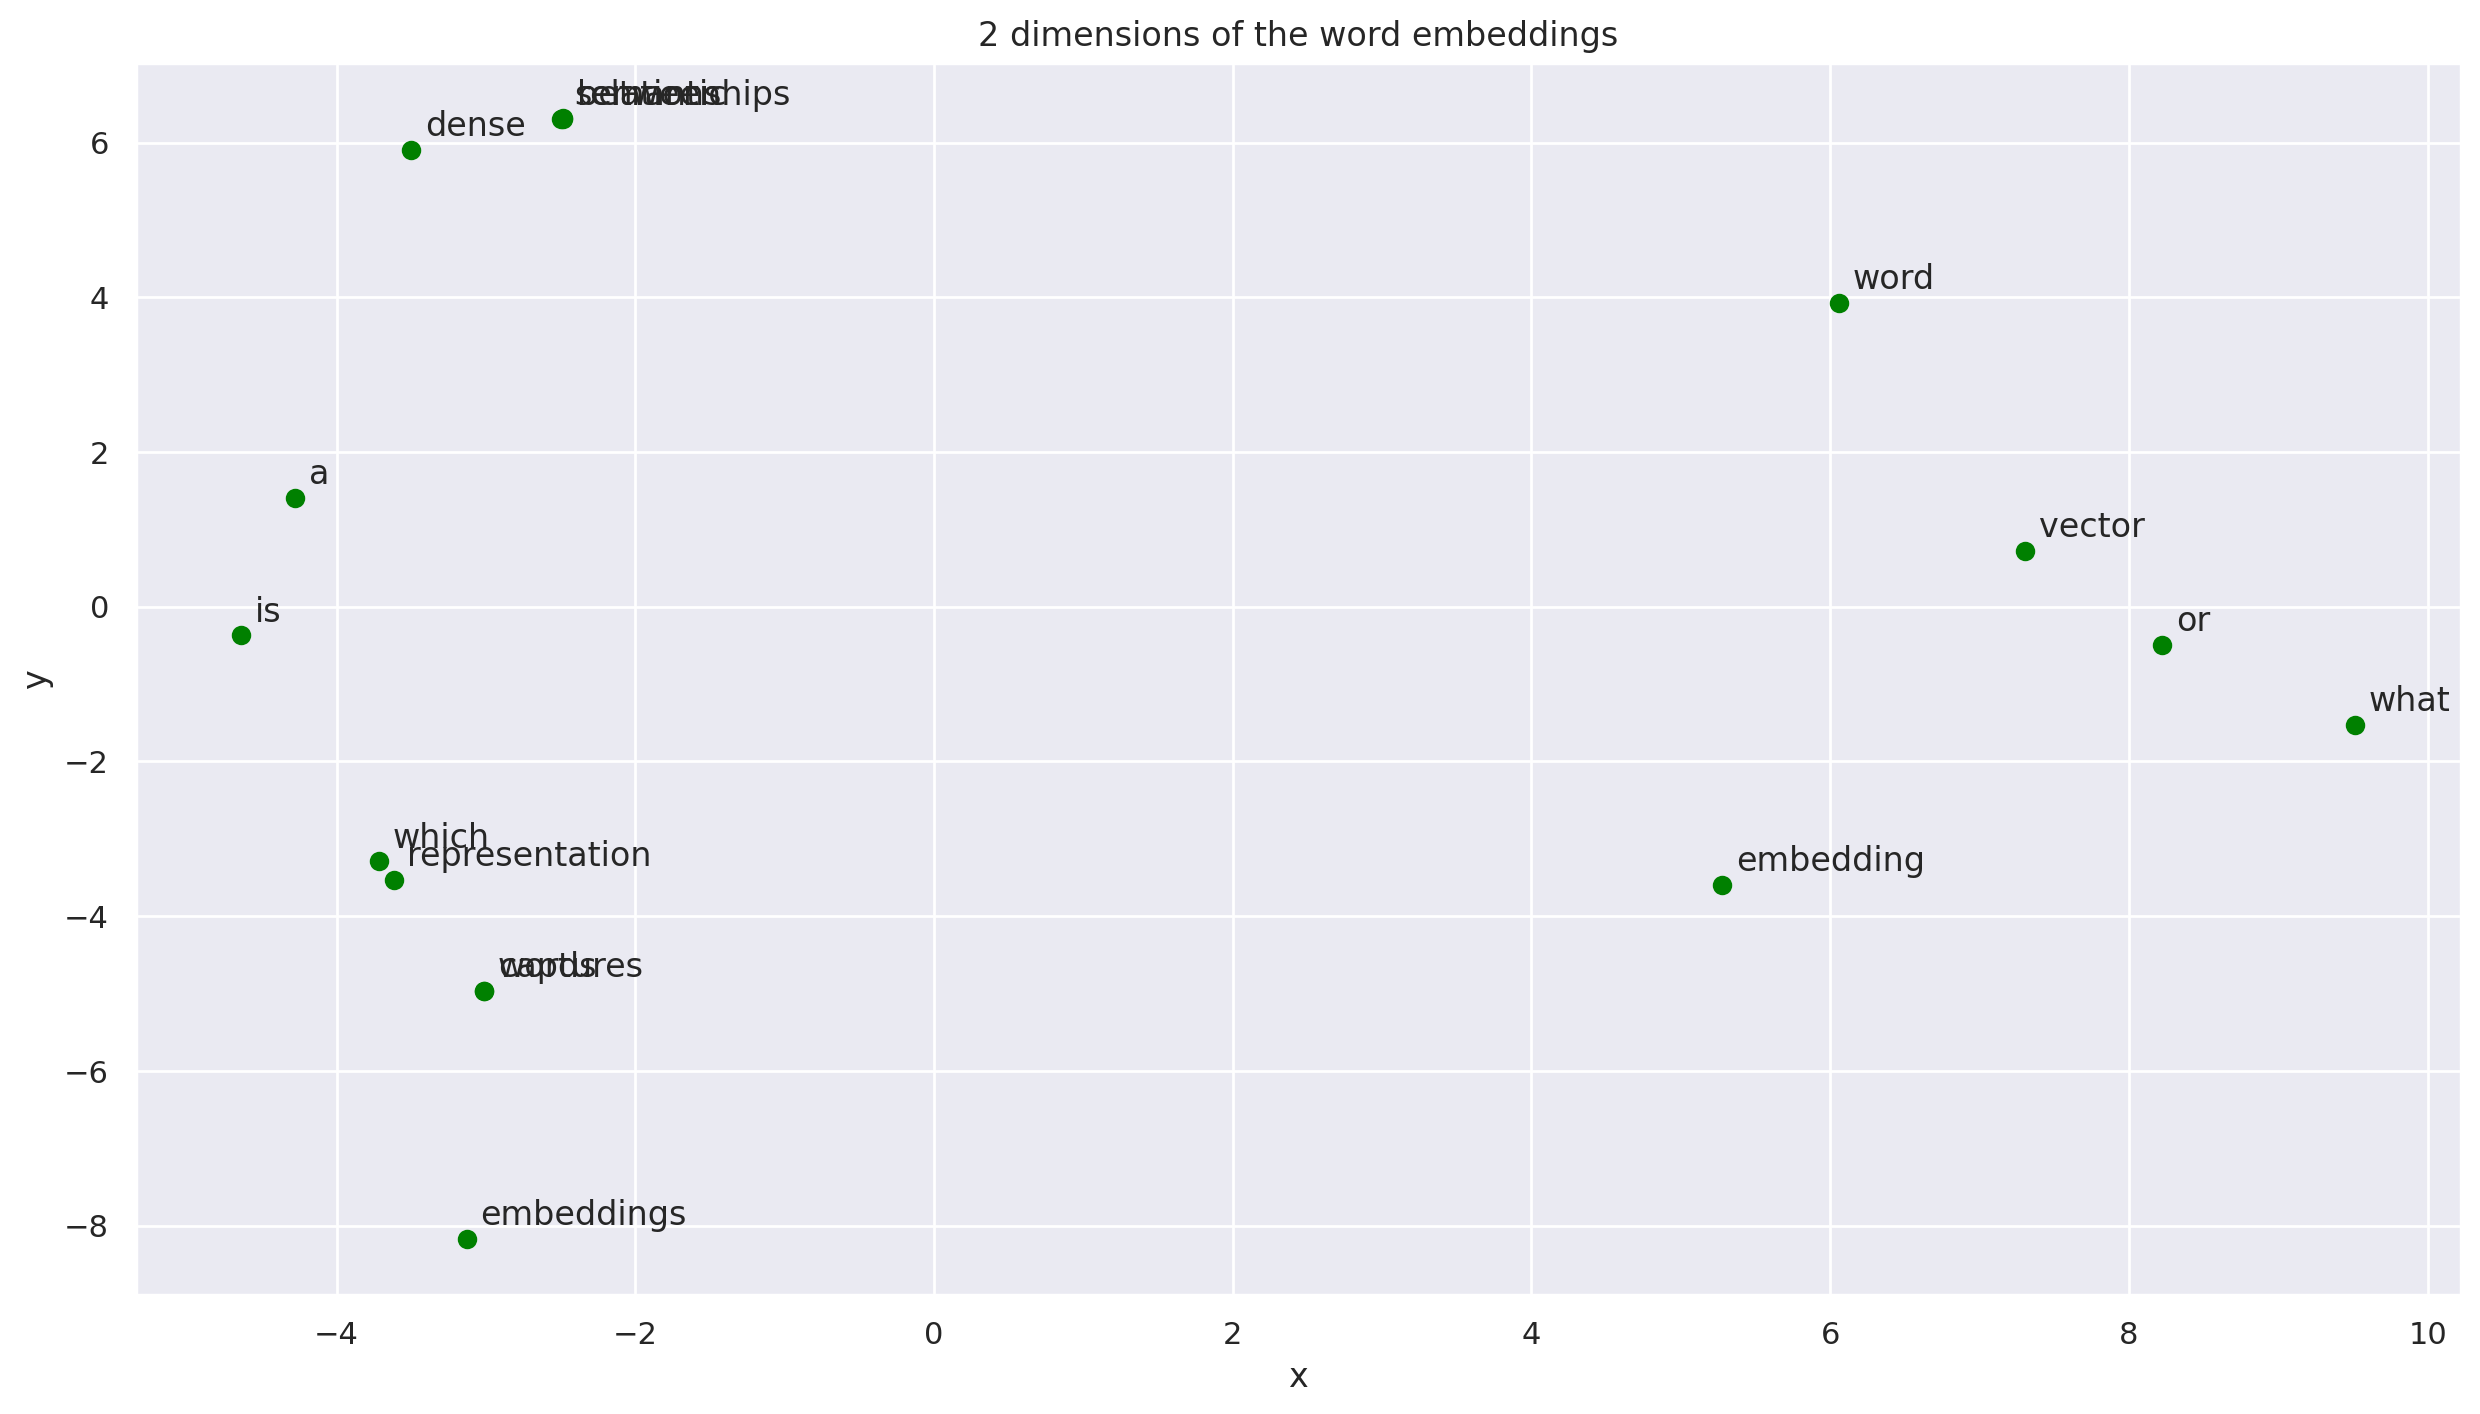

In [40]:
plot_embedding(parameters["best_embeddings"], test_xs[0], vocab)

In [41]:
parameters["best_embeddings"].shape

(16, 50)

In [42]:
# Let's calculate the cosine distance between all words

cos_dists = scipy.spatial.distance.cdist(
    parameters["best_embeddings"], parameters["best_embeddings"], "cosine"
)
cos_dists.shape
vocab

['a',
 'is',
 'word',
 'what',
 'embedding',
 'vector',
 'or',
 'embeddings',
 'dense',
 'representation',
 'which',
 'captures',
 'semantic',
 'relationships',
 'between',
 'words']

In [43]:
def costs_heatmap(costs, vocab):
    plt.figure(figsize=(9, 8))
    sns.heatmap(
        costs,
        annot=costs.round(1),
        xticklabels=vocab,
        yticklabels=vocab,
        cmap="RdPu",
    )

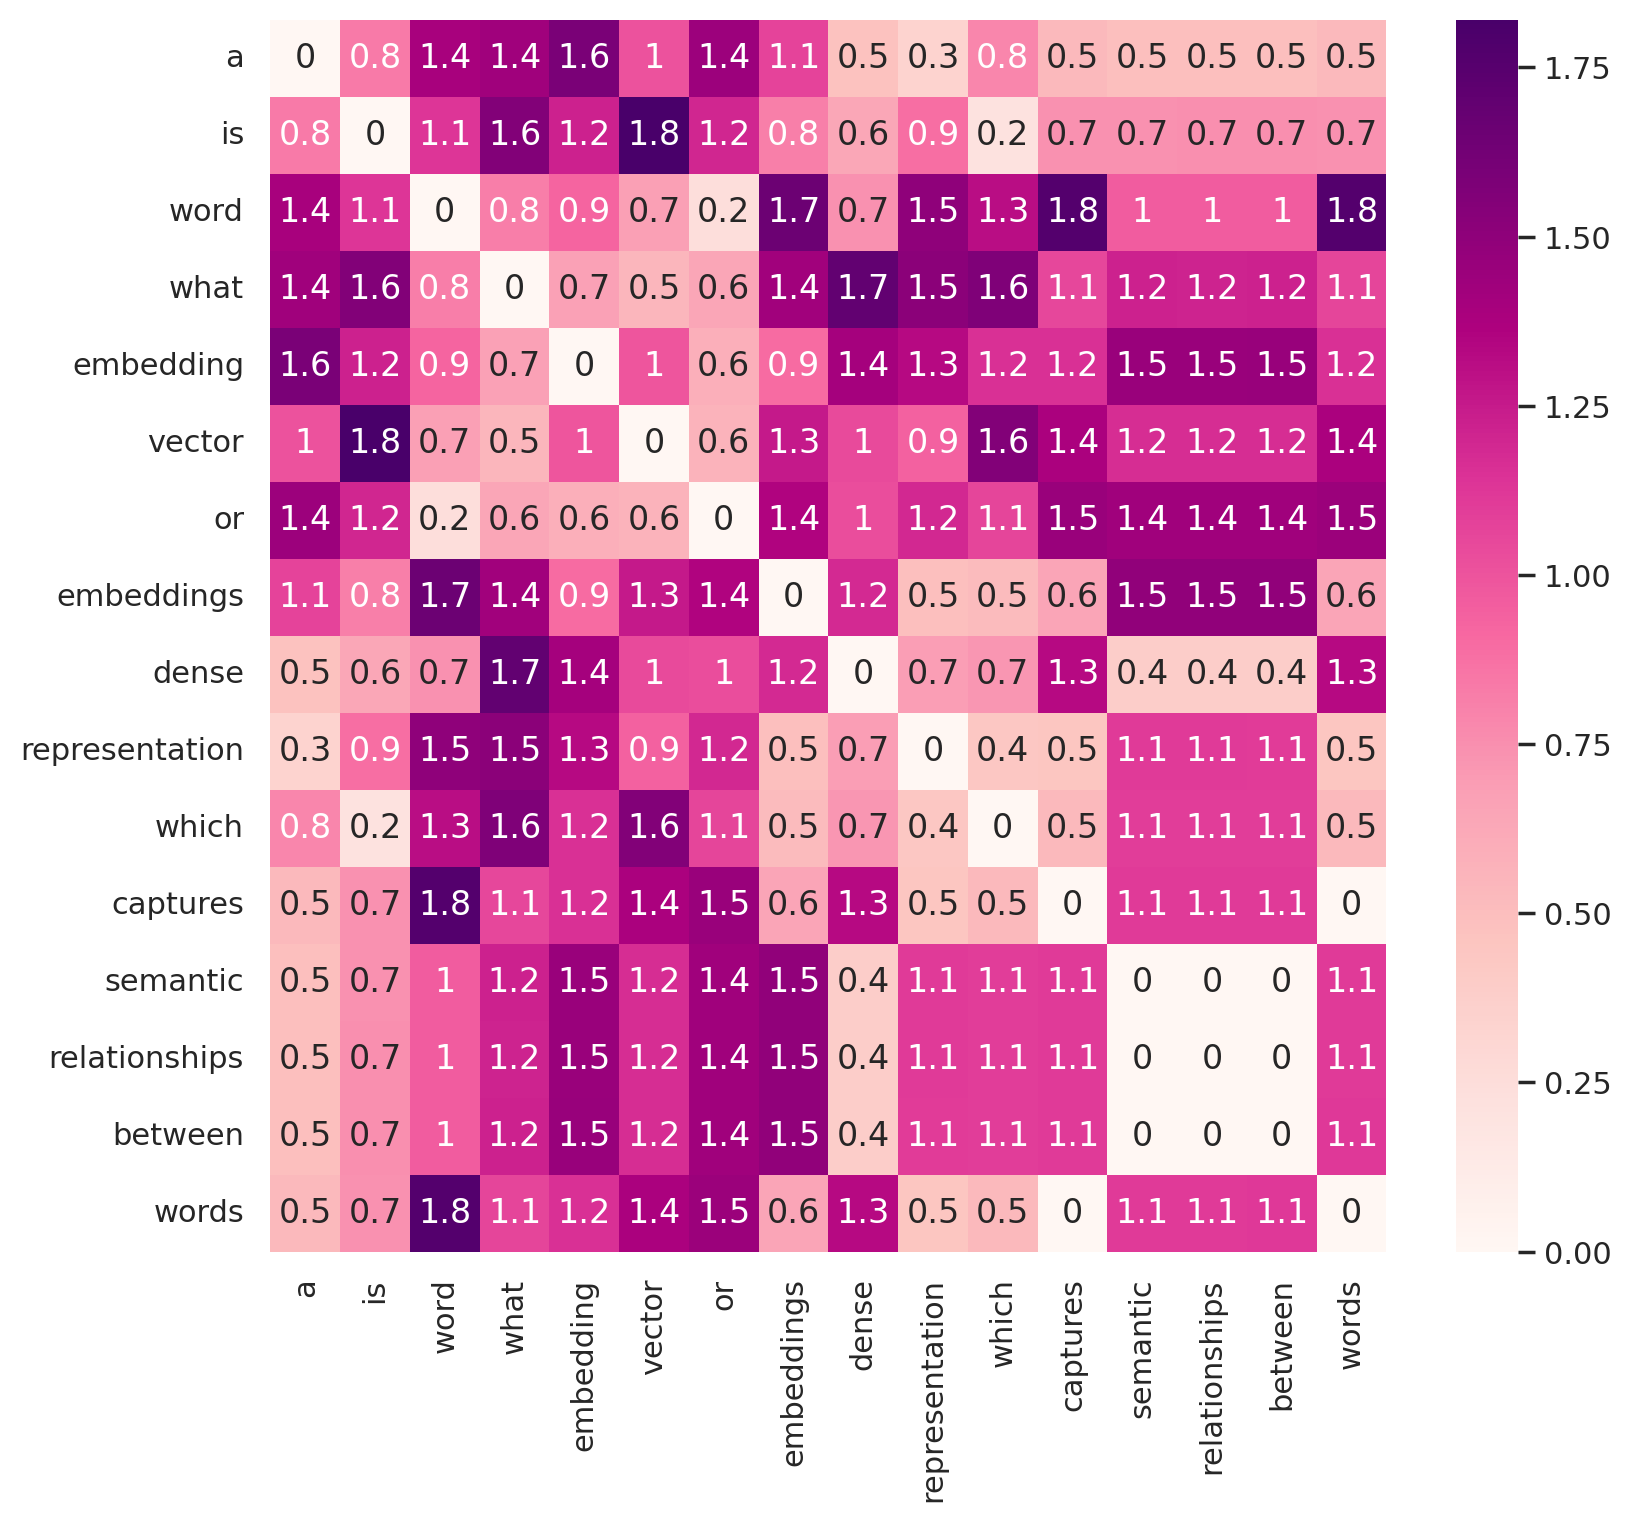

In [44]:
costs_heatmap(cos_dists, vocab)

In [ ]:
### 🚧 attempt a short hande-waving explanations of what you see in the heatmap

## A longer text

In [45]:
text = """The celestial sphere is an imaginary projection of the Sun, Moon,
planets, stars, and all astronomical bodies upon an imaginary sphere surrounding
Earth. Although originally developed as part of the ancient Greek concept of an
Earth-centered (geocentric) universe, the hypothetical celestial sphere gives
astronomers an important tool for fixing the location and plotting movements of
celestial objects. Ancient Greek astronomers envisioned concentric crystalline
spheres centered around Earth, upon which the Sun, Moon, planets, and stars
moved. Although heliocentric (Sun-centered) models of the universe were also
proposed by the Greeks, they were disregarded as counterintuitive to the
apparent motions of celestial bodies across the sky. Corresponding to Earth’s
rotation, the celestial sphere rotates through 1° in about four minutes. Because
of this, sunrise, sunset, moonrise, and moon-set, all take approximately two
minutes because both the Sun and Moon have the same apparent size on the
celestial sphere (about 0.5°). The Sun is, of course, much larger, but the Moon
is much closer. """

### Do the same thing again

for this larger text

In [77]:
tokens = tokenize(text)
print(Counter(tokens))

vocab1, voc2idx1 = build_vocab(tokens, show_df=True)
xs, ys = generate_skip_data(tokens, 3)

xs, ys = np.array(xs), np.array(ys)
vocab_size = len(vocab1)

m = ys.shape[1]
print("m:", m)

Counter({'the': 16, 'of': 8, 'celestial': 6, 'sphere': 5, 'sun': 5, 'moon': 5, 'and': 5, 'an': 4, 'earth': 4, 'is': 3, 'centered': 3, 'imaginary': 2, 'planets': 2, 'stars': 2, 'all': 2, 'bodies': 2, 'upon': 2, 'although': 2, 'as': 2, 'ancient': 2, 'greek': 2, 'universe': 2, 'astronomers': 2, 'were': 2, 'to': 2, 'apparent': 2, 'about': 2, 'minutes': 2, 'because': 2, 'much': 2, 'projection': 1, 'astronomical': 1, 'surrounding': 1, 'originally': 1, 'developed': 1, 'part': 1, 'concept': 1, 'geocentric': 1, 'hypothetical': 1, 'gives': 1, 'important': 1, 'tool': 1, 'for': 1, 'fixing': 1, 'location': 1, 'plotting': 1, 'movements': 1, 'objects': 1, 'envisioned': 1, 'concentric': 1, 'crystalline': 1, 'spheres': 1, 'around': 1, 'which': 1, 'moved': 1, 'heliocentric': 1, 'models': 1, 'also': 1, 'proposed': 1, 'by': 1, 'greeks': 1, 'they': 1, 'disregarded': 1, 'counterintuitive': 1, 'motions': 1, 'across': 1, 'sky': 1, 'corresponding': 1, 's': 1, 'rotation': 1, 'rotates': 1, 'through': 1, '1': 1, 

,token,count
0,the,16
1,of,8
2,celestial,6
3,sphere,5
4,sun,5
...,...,...
89,5,1
90,course,1
91,larger,1
92,but,1


m: 984


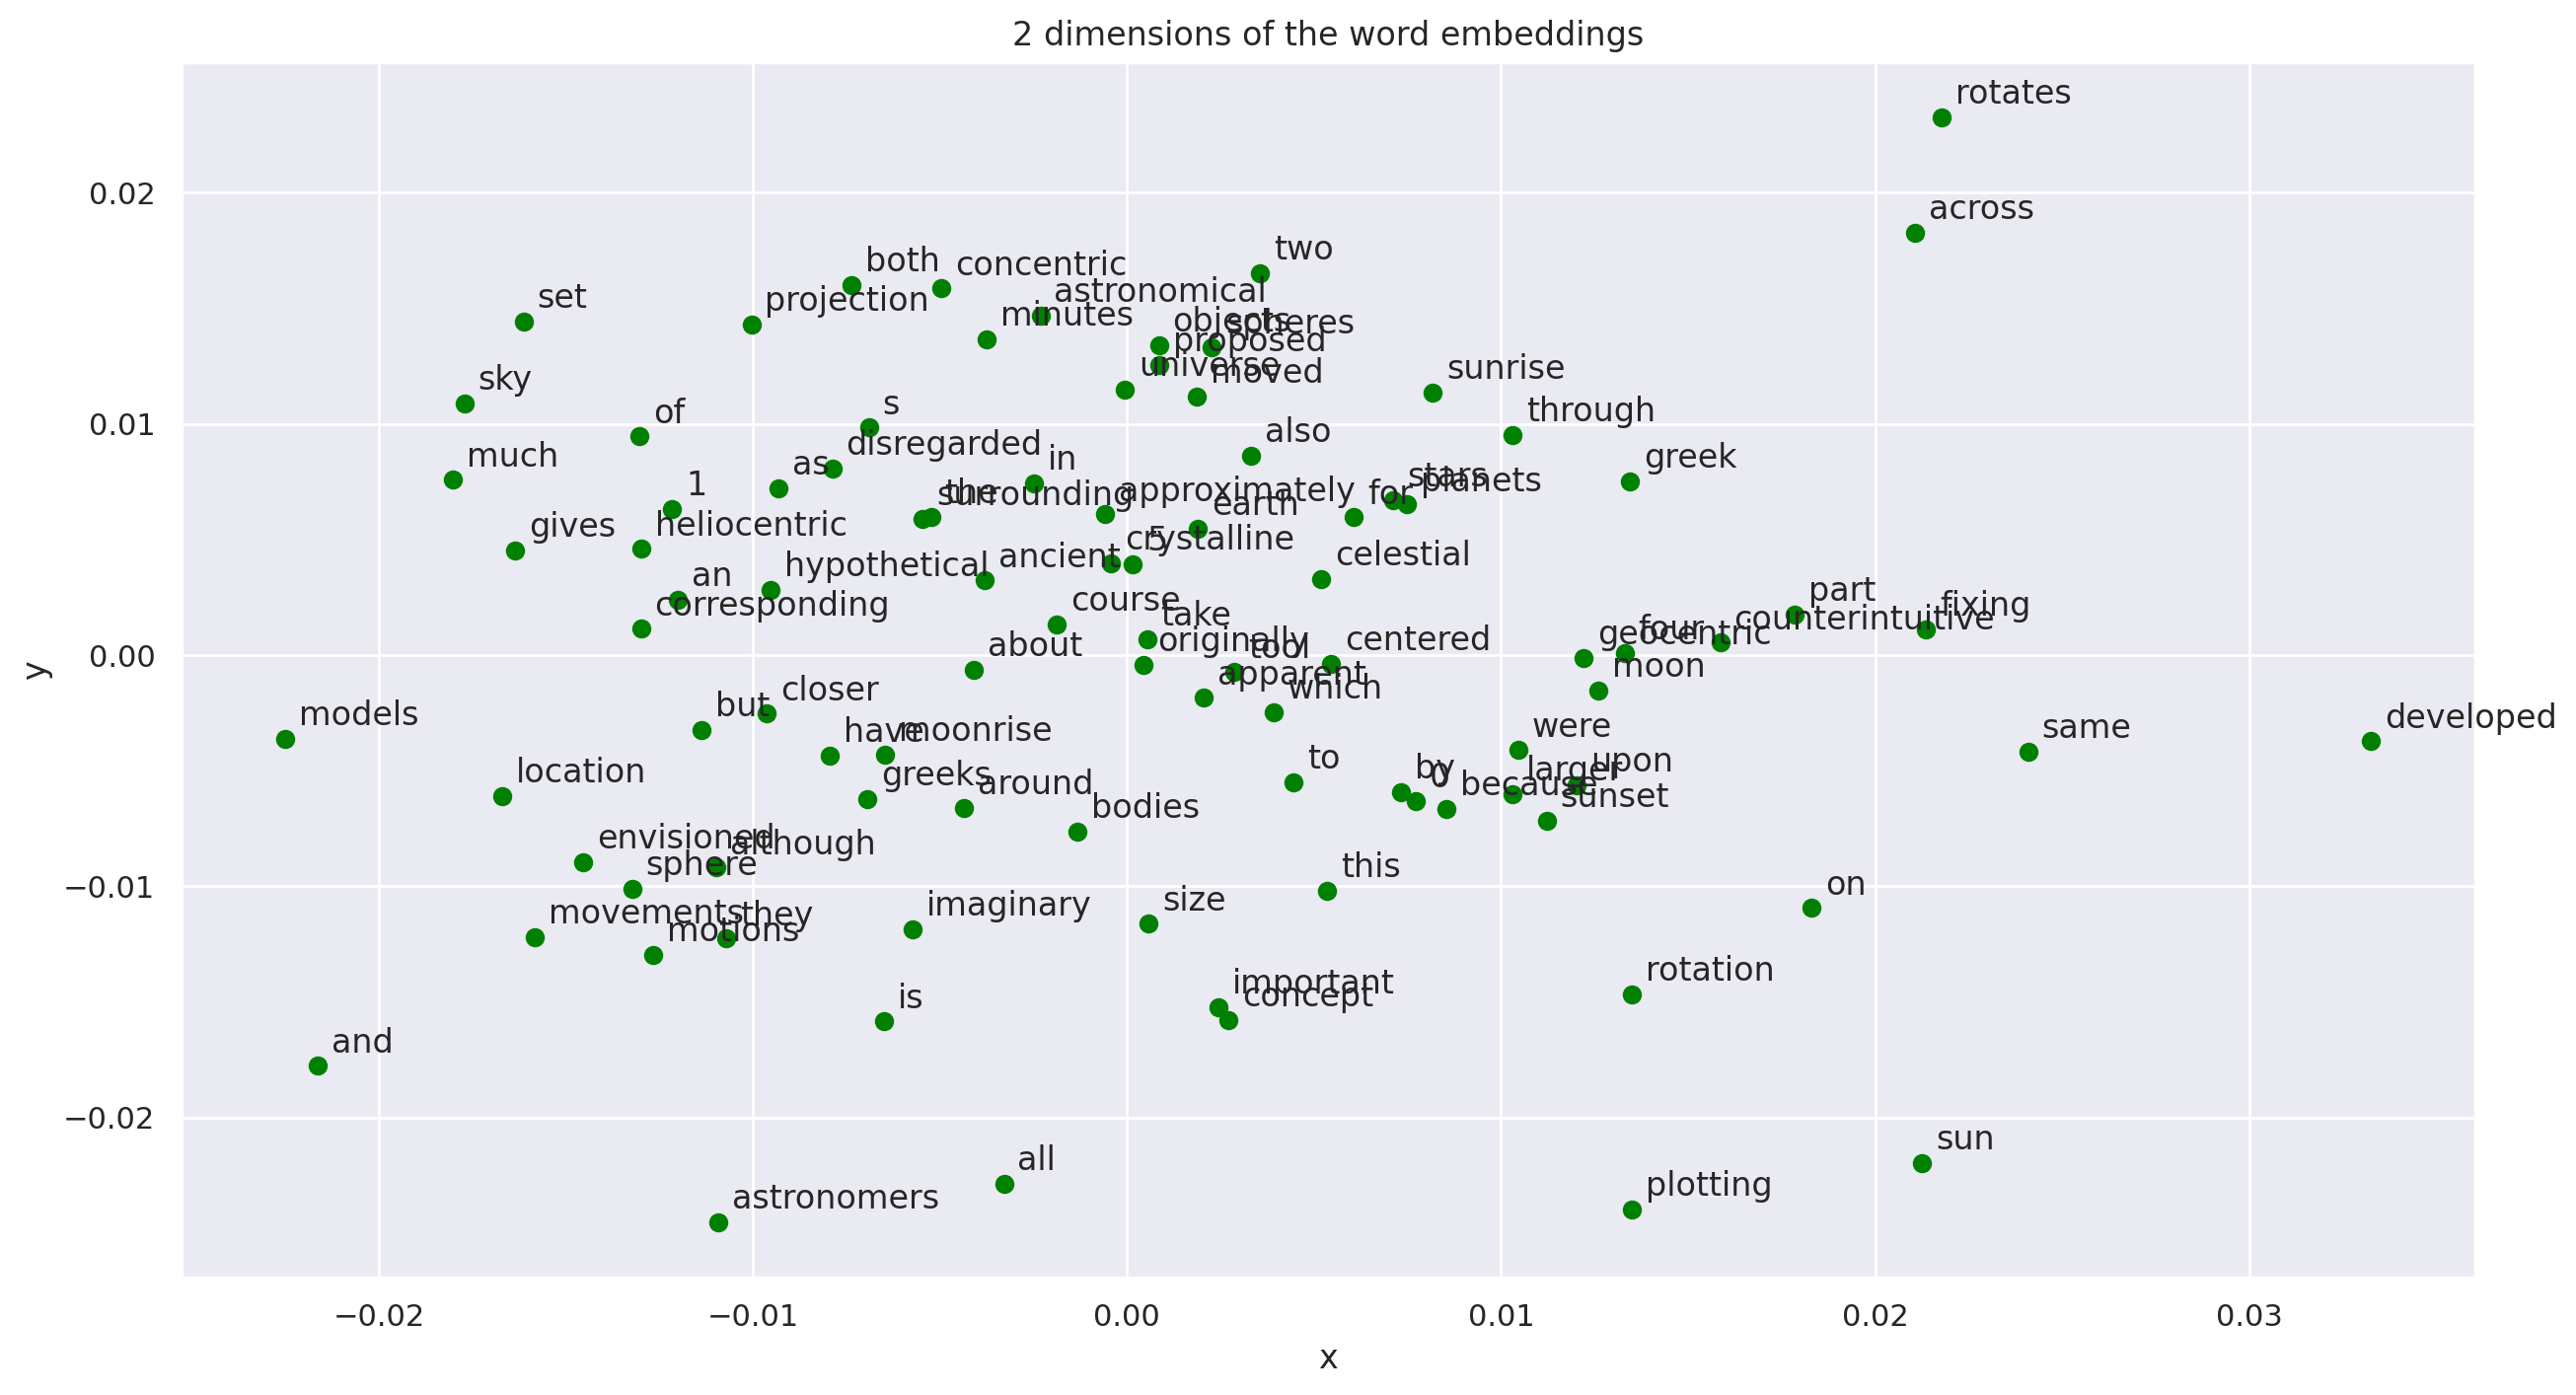

In [78]:
# Initialize the parameters and visualize the distribution (normal, random)
parameters = initialize_parameters(len(vocab1), 5)
plot_embedding(parameters["EMBS"], voc2idx1.values(), vocab1)

Cost after epoch    0: 36.3463
Cost after epoch  200: 34.3176
Cost after epoch  400: 29.8460
Cost after epoch  600: 27.6375
Cost after epoch  800: 26.9318
Cost after epoch 1000: 26.9170
Cost after epoch 1200: 27.0092
Cost after epoch 1400: 26.7605
Cost after epoch 1600: 26.6696
Cost after epoch 1800: 26.5603
Cost after epoch 2000: 26.6352
Cost after epoch 2200: 26.7387
Cost after epoch 2400: 26.7332
Cost after epoch 2600: 26.6264
Cost after epoch 2800: 26.5317
Cost after epoch 3000: 26.5266
Cost after epoch 3200: 26.5523
Cost after epoch 3400: 26.5506
Cost after epoch 3600: 26.5468
Cost after epoch 3800: 26.5718
Cost after epoch 4000: 26.6105
Cost after epoch 4200: 26.6423
Cost after epoch 4400: 26.6595
Cost after epoch 4600: 26.6565
Cost after epoch 4800: 26.6370
training time: 0:00:12.080770
🚧 TODO I've kept the embedding of epoch 2906 with cost 26.5088.


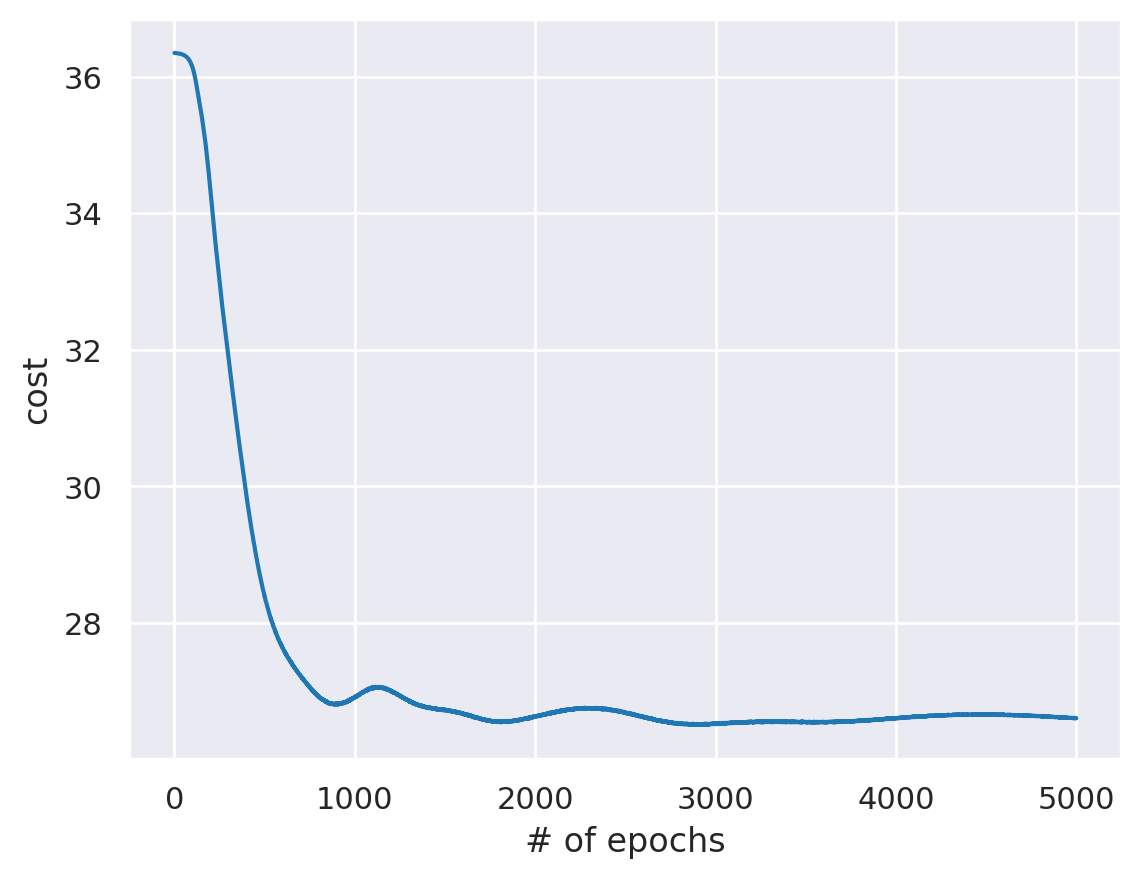

In [79]:
# Be patient:
parameters = skipgram_model_training(
    xs,
    ys,
    vocab_size,
    emb_size=50,
    learning_rate=0.05,
    epochs=5000,
    batch_size=128,
    parameters=None,
    print_cost=True,
)

In [81]:
# 🚧 TODO: as before find the predicted words from the context
test_xs = np.arange(vocab_size)
test_xs = np.expand_dims(test_xs, axis=0)
softmax_test, _ = forward_propagation( test_xs, parameters)
top_sorted_inds = np.argsort(softmax_test, axis=0)[-5:][::-1]
for input_ind in range(10):
    ...
    print(f"{input_word}'s neighbor words: {output_words}") 
# end TODO

let's neighbor words: ['which', 'dense', 'semantic', 'relationships', 'between']
let's neighbor words: ['which', 'dense', 'semantic', 'relationships', 'between']
let's neighbor words: ['which', 'dense', 'semantic', 'relationships', 'between']
let's neighbor words: ['which', 'dense', 'semantic', 'relationships', 'between']
let's neighbor words: ['which', 'dense', 'semantic', 'relationships', 'between']
let's neighbor words: ['which', 'dense', 'semantic', 'relationships', 'between']
let's neighbor words: ['which', 'dense', 'semantic', 'relationships', 'between']
let's neighbor words: ['which', 'dense', 'semantic', 'relationships', 'between']
let's neighbor words: ['which', 'dense', 'semantic', 'relationships', 'between']
let's neighbor words: ['which', 'dense', 'semantic', 'relationships', 'between']


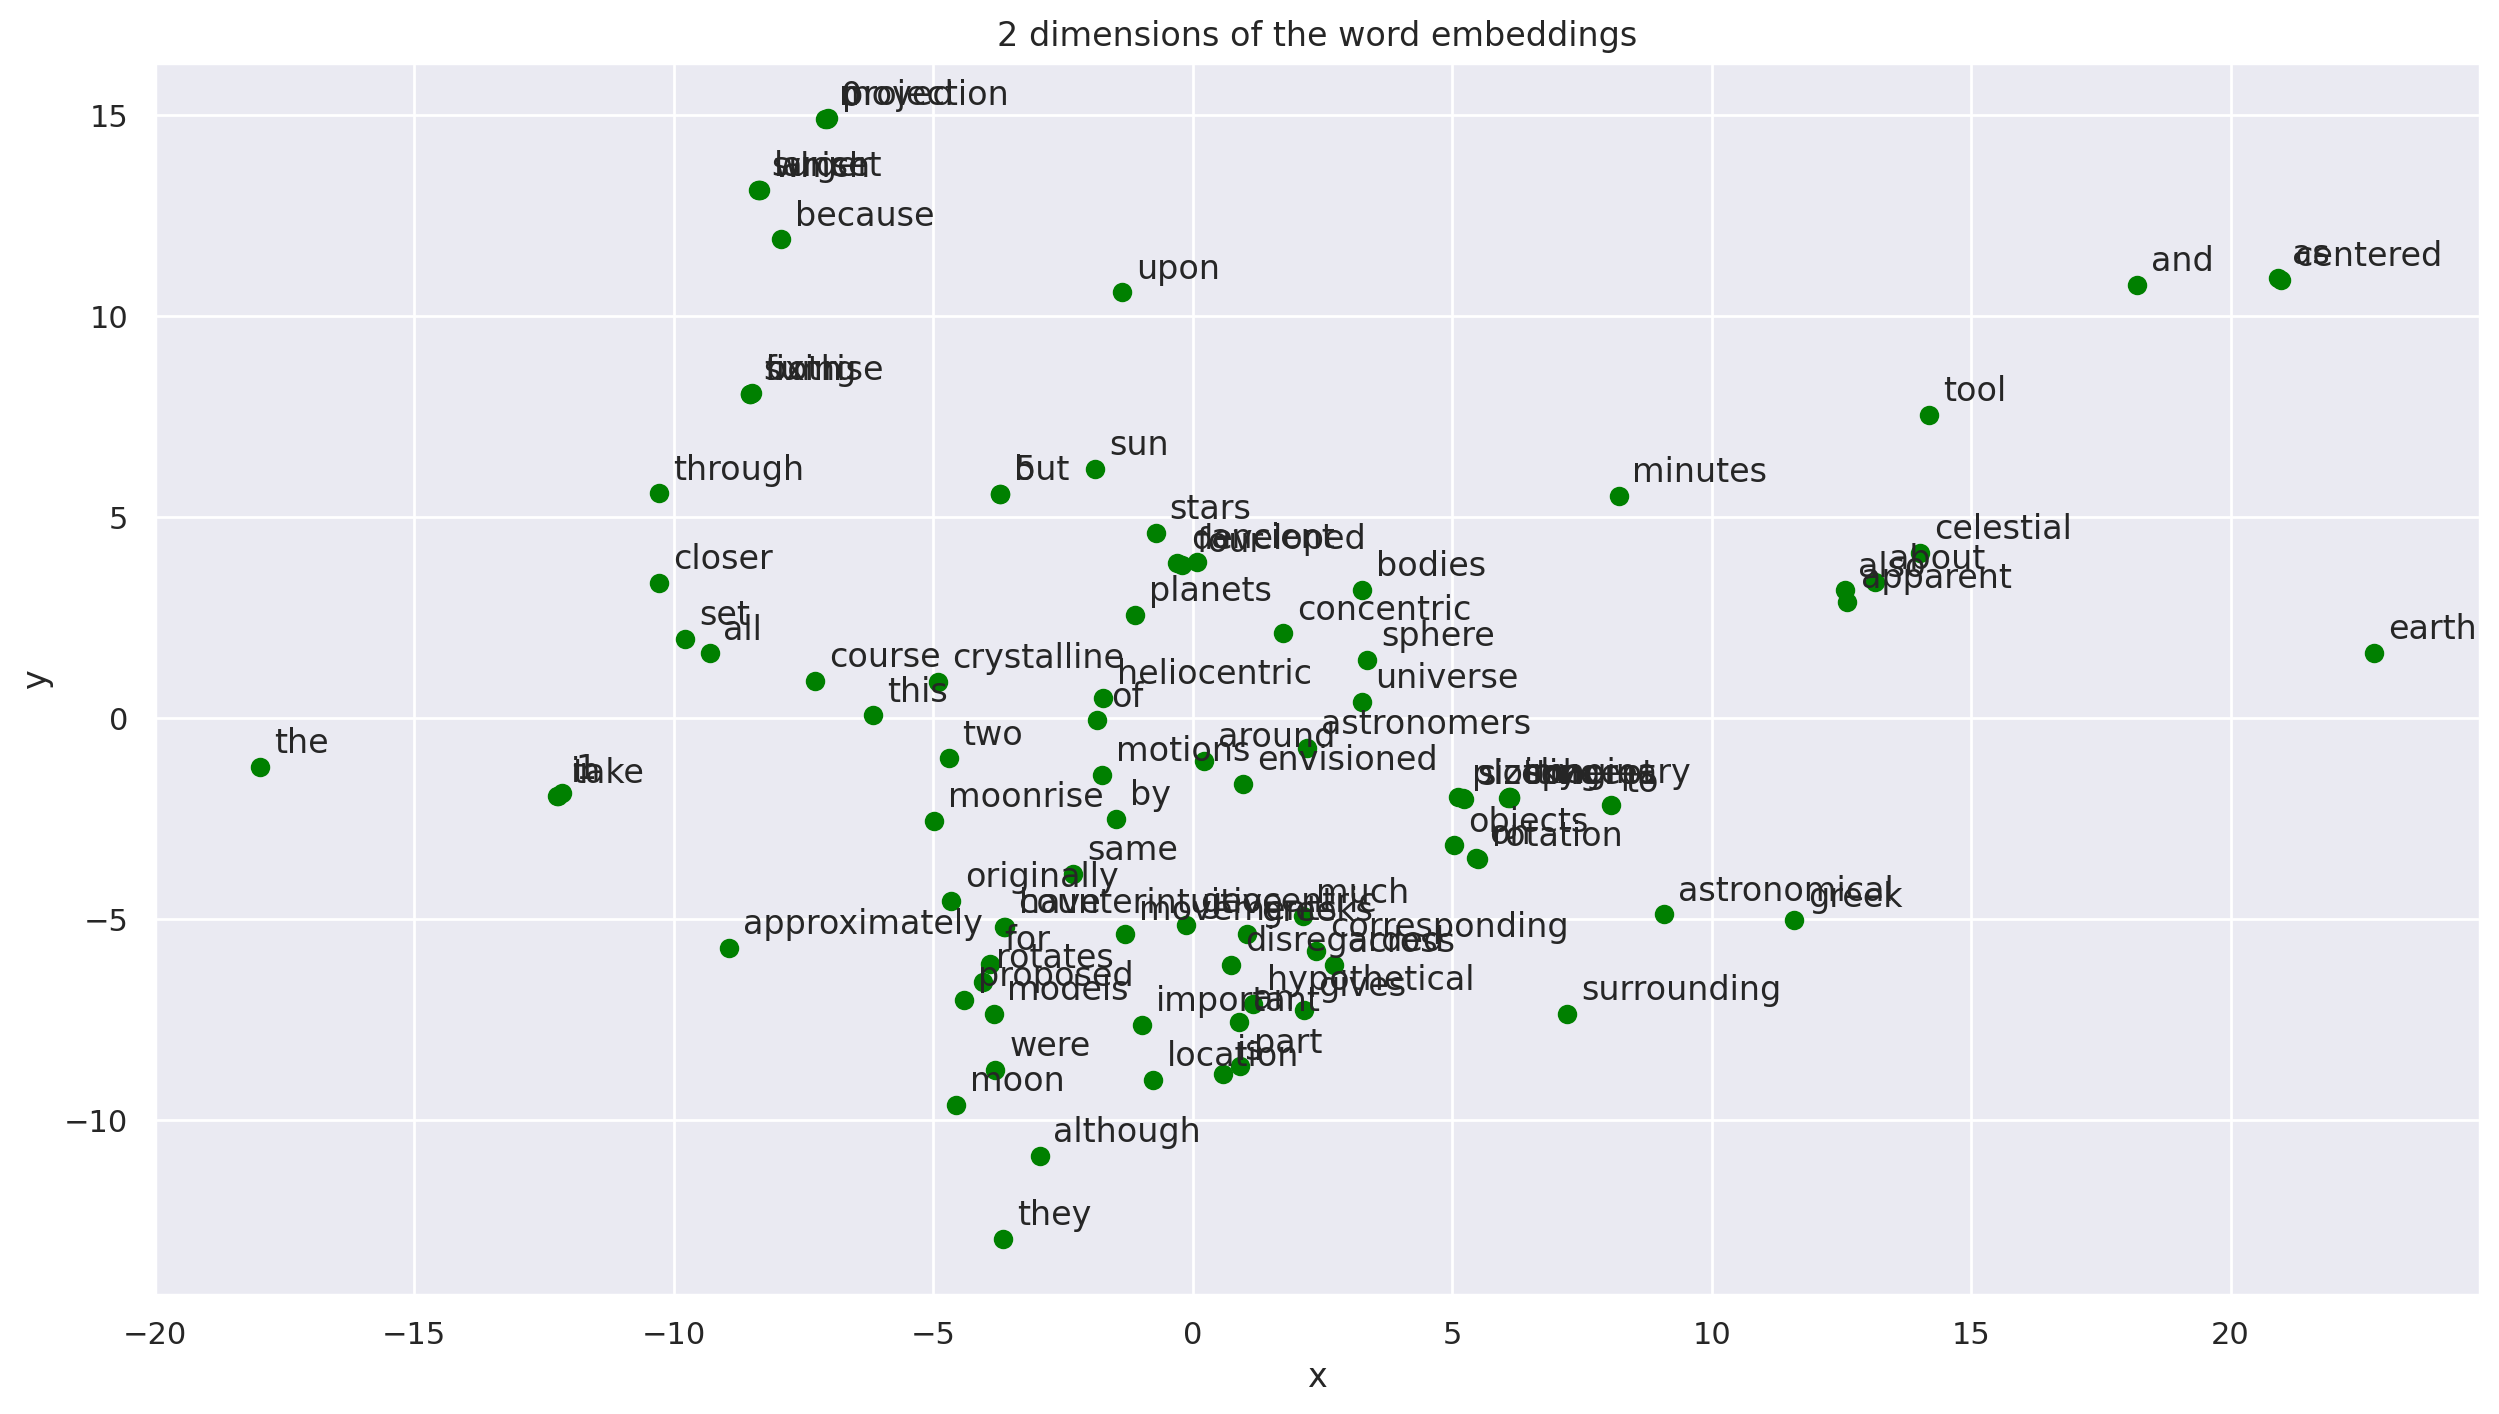

In [82]:
plot_embedding(parameters["EMBS"], voc2idx1.values(), vocab1)

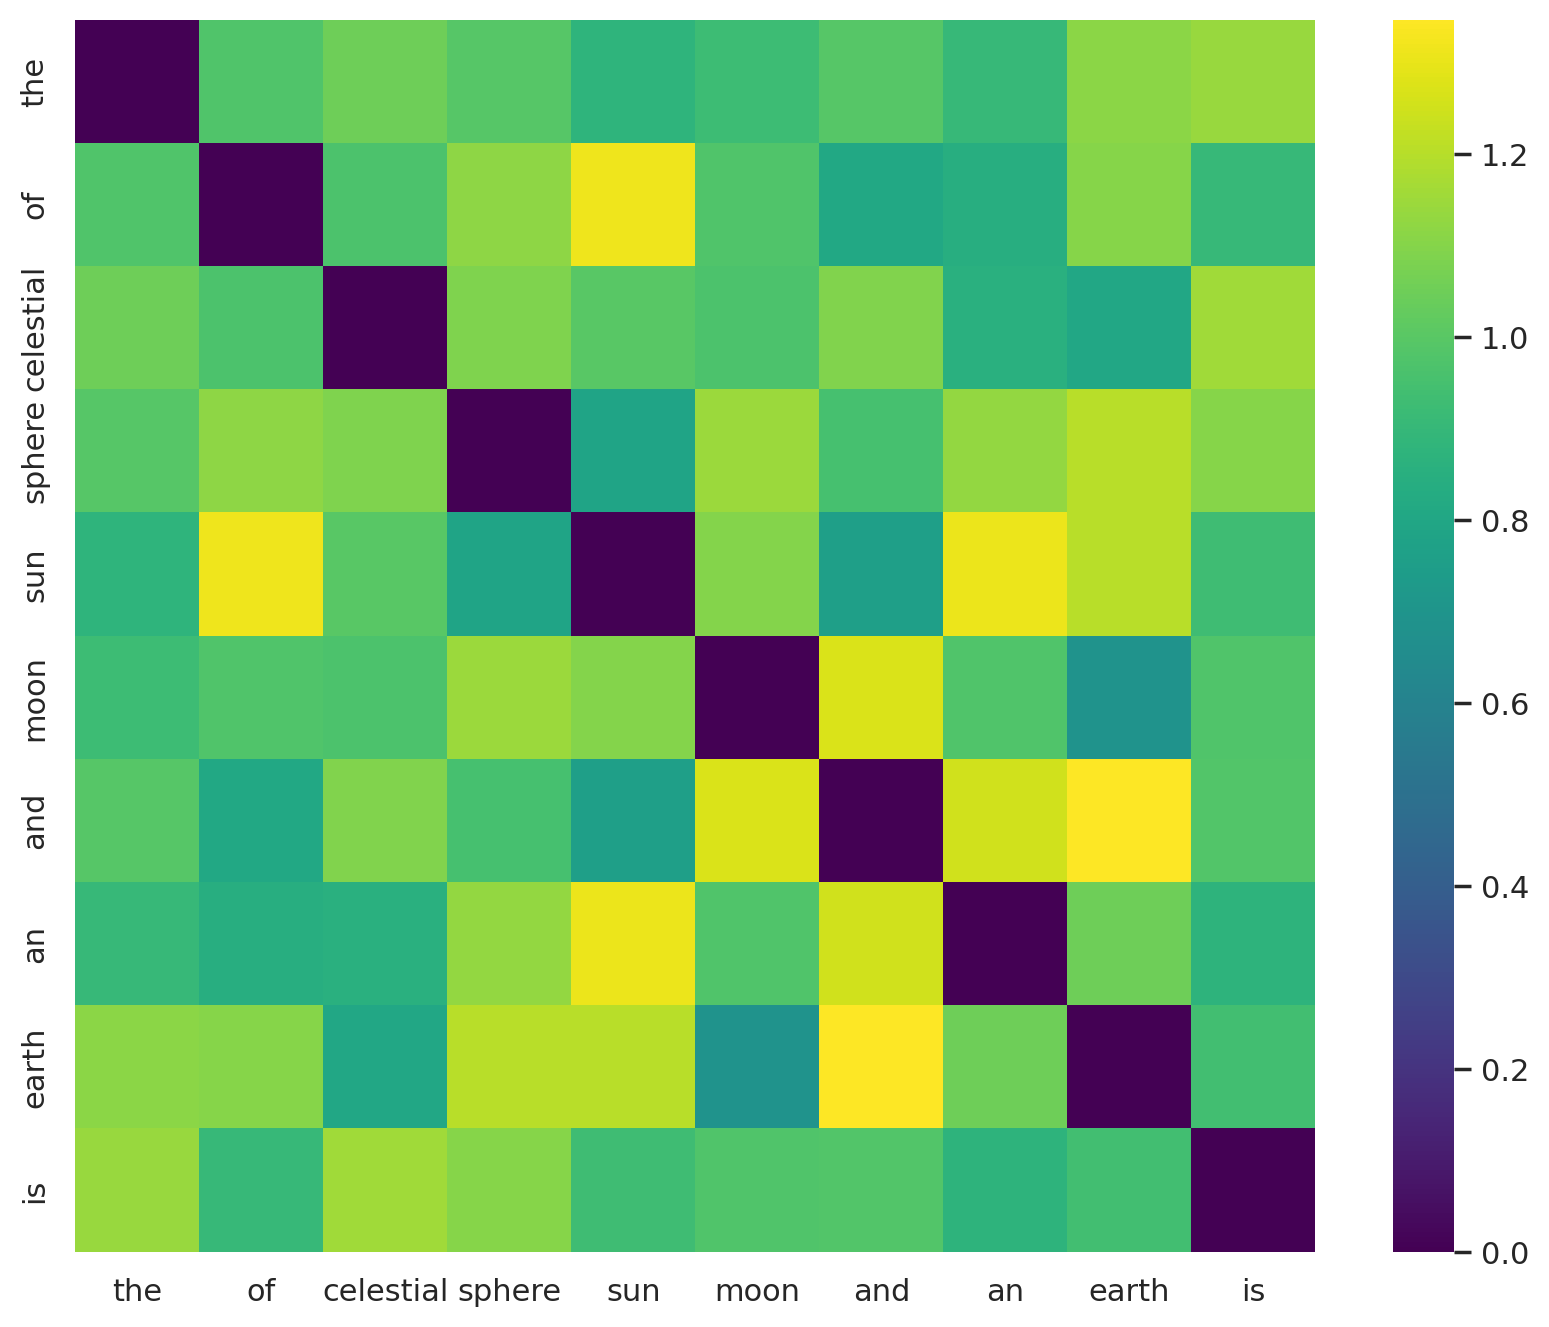

In [84]:
vocab_size = len(vocab1)
emb_size = 50  # You can adjust the embedding size as needed
parameters = {"best_embeddings": initialize_embeddings(vocab_size, emb_size)}

# Select the top N most frequent words
N = 10  # You can adjust this number as needed
top_vocab = vocab1[:N]
top_indices = [voc2idx1[word] for word in top_vocab]

# Filter the embeddings to include only the top N words
top_embeddings = parameters["best_embeddings"][top_indices, :]

# Compute cosine distances for the filtered embeddings
cos_dists = scipy.spatial.distance.cdist(top_embeddings, top_embeddings, "cosine")

# Generate the heatmap for the reduced set of words
def costs_heatmap(cos_dists, vocab1):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cos_dists, xticklabels=vocab1, yticklabels=vocab1, cmap="viridis")
    plt.show()

costs_heatmap(cos_dists, top_vocab)

### Conclusions:

- It works, but we would like to train on a much larger corpus

  - For that, we should:
  
    - Not exceed the lines when computing the neighborhood
  
    - Use negative sampling
  
    - Maybe implement a part in C and optimized for graphic card --
      or use a deep learning module (PyTorch, TensorFlow...)

- We will rely on an already implemented module: **Gensim**

→ Next section

____________

### 🌸 Gensim Word Embedding

- Word embedding

  - 🚧 TODO: complete a function to read a pre-computed embedding

  - 🚧 TODO: normalize vectors

  - 🚧 TODO: complete the function that finds the closest words by cosine distance

  - 🚧 TODO: test the nearest words

  - 🚧 mini-TODO: complete and test the function that computes analogies to see if our plotting is biased

- Later: text classification

  - 🚧 TODO: find and remove an outlier in our texts (to understand that the method works very well if the texts are very different)

  - Optional TODO: other methods than k-nearest neighbors

  - Optional TODO: redo based on keywords only

All TODOs are marked with the symbol 🚧

#### Load the pre-calculated word2vec
  
  - Get `enwiki-50k_100d.txt` from [here](https://gitlab.inria.fr/flandes/data-for-teaching/-/blob/master/enwiki-50k_100d.txt) and put it next to your notebook

  - It consists in a reduction to the 50k most frequent types of the full word2vec [pretrainded](https://wikipedia2vec.github.io/wikipedia2vec/pretrained/) on the complete English Wikipedia.  
  
    In particular this [file](http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.txt.bz2)
  
  - Open the file and explore the format
  
  - 🚧 Write a `read_vectors` function that gives a numpy matrix `embeddings` with one row per type (~ one word), each row represents the word. `embeddings[i, :]` corresponds to one type.

In [64]:
import numpy as np

def read_vectors(vocab_size=50000, dimension=100):
    """
    Function that reads a backup of an embedding.
    
    Returns:
    - w2i (dict): A word-to-index dictionary.
    - i2w (dict): An index-to-word dictionary.
    - embeddings (np.ndarray): A matrix containing a vector of words per word type.
    
    The file format is expected to have each line with a word followed by its embedding values.
    """
    embeddings = np.zeros((vocab_size, dimension))
    w2i, i2w = {}, {}  # as before
    i = 0
    with open("enwiki-50k_100d.txt") as f:
        for line in f.readlines():
            # 🚧 TODO:
            splitted = line.strip().split()
            word = splitted[0]
            vector = np.array(splitted[1:], dtype=float)
            w2i[word] = i
            i2w[i] = word
            embeddings[i] = vector
            i += 1
            # end TODO
    assert len(w2i) == len(i2w) == len(embeddings)
    return w2i, i2w, embeddings

In [65]:
w2i, i2w, embeddings = read_vectors()

print(len(w2i), len(i2w), embeddings.shape)

50000 50000 (50000, 100)


### Objectives

We want to make a python function that for a given word returns the K nearest (semantic) neighbors

To do this, we need to

1. calculate the cosine distance between them

2. order the distances by decreasing orders


#### 1. Calculating the cosine distance
**Hint**, we can do this in two substeps:
- 🚧 normalize the embeddings (with respect to the rows, i.e., each word vector to a unit norm)
- 🚧 calculate scalar product between the source word embedding with the whole embedding space

In [66]:
# 🚧 TODO: normalize the embeddings (with respect to the lines,
#     i.e. each word vector to a unit norm)

norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
normed_embeddings = embeddings / norms

# end TODO

# Verify normalization
print(np.linalg.norm(normed_embeddings, axis=1))  # Should print an array of ones

[1. 1. 1. ... 1. 1. 1.]


**⚠ Achtung!!!**:

- To simplify the calculations later, we will base our calculations on the `normed_embeddings` matrix. Thus, we won't need to divide the dot product of the two vectors by their norms (the cosine similarity of two unit vectors is just the dot product of the vectors).

- If you want to perform a similarity calculation based on another measure (Euclidean distance?), then you will have to base your calculations on the raw `embeddings` matrix (which is not normalized!)

In [67]:
def find_closest_words_from_vector(vector, k_max=10):
    """For a given vector, find the K nearest semantic neighbors"""
    closest_words = []

    # Compute cosine similarities (dot product with normalized embeddings)
    cosine_similarities = np.dot(normed_embeddings, vector)

    # Sort indices by cosine similarity in descending order
    sorted_indexes = np.argsort(cosine_similarities)[::-1]

    # Only K largest is of interest to us
    for k in range(1, k_max + 1):  # to take the last elements, we start with -1
        neighboor_index = sorted_indexes[k]
        closest_words.append((i2w[neighboor_index], cosine_similarities[neighboor_index]))

    return closest_words

In [68]:
def find_closest_words_from_word(word, k_max=10):
    """For a given word 'word', find the K nearest semantic neighbors"""
    word_index = w2i[word]
    word_vector = normed_embeddings[word_index]
    closest_words = find_closest_words_from_vector(word_vector, k_max)
    return closest_words

In [69]:
def pretty_show(closest_words):
    """prettify the print for the closest words"""
    for word, similarity in closest_words:
        print(word.ljust(15, " "), similarity.round(3))
    print("___\n")

In [70]:
# Creative time! Let's test our function on some terms
pretty_show(find_closest_words_from_word("french"))
pretty_show(find_closest_words_from_word("what"))
# trained on Wikipédia. --> few swear words... (e.g., holy ...)
pretty_show(find_closest_words_from_word("holy"))
pretty_show(find_closest_words_from_word("cool"))

françois        0.733
belgian         0.729
haitian         0.723
leclerc         0.711
spanish         0.709
étienne         0.706
algerian        0.704
france          0.698
pierre          0.69
alsatian        0.688
___

why             0.83
really          0.829
whatever        0.816
something       0.81
everything      0.807
nothing         0.806
definitely      0.804
how             0.799
actually        0.788
know            0.788
___

blessed         0.735
redeemer        0.725
sacrament       0.724
sacred          0.721
rosary          0.72
sepulchre       0.72
baptism         0.685
saviour         0.676
eucharist       0.671
trinity         0.668
___

warm            0.836
chilly          0.771
hot             0.746
sunny           0.741
cooler          0.734
cold            0.733
winters         0.733
wet             0.727
summers         0.724
chill           0.719
___



### Analogies

Finally the pretty analogies in the embeddings!

In [71]:
def find_analogies(wpos1, wpos2, wneg):
    """
    wpos1: the first positive word
    wpos2: the 2nd positive word
    wneg: the negative word
    Find the analog "analog" such that
        <"analog" is to "wpos2" what "wneg" is to "wpos1">
    For example: <"queen" is to "woman" what "king" is to "man">
    """
    # add the positive vectors, subtract the negative vector:
    vector_analog = normed_embeddings[w2i[wpos1]] - normed_embeddings[w2i[wneg]] + normed_embeddings[w2i[wpos2]]
    return find_closest_words_from_vector(vector_analog)

In [73]:
# Existing examples
pretty_show(find_analogies("king", "woman", "man"))
pretty_show(find_analogies("nurse", "man", "woman"))  # Watch out for bias!

# 🚧 TODO: Find other "questionable" examples

# Example 1: Gender bias in professions
pretty_show(find_analogies("doctor", "woman", "man"))
pretty_show(find_analogies("teacher", "man", "woman"))

# Example 2: Nationality and stereotypes
pretty_show(find_analogies("american", "hamburger", "pizza"))
pretty_show(find_analogies("italian", "pasta", "sushi"))

# Example 3: Gender bias in roles
pretty_show(find_analogies("father", "woman", "man"))
pretty_show(find_analogies("mother", "man", "woman"))

# Example 4: Cultural stereotypes
pretty_show(find_analogies("rich", "poor", "wealthy"))
pretty_show(find_analogies("happy", "sad", "joyful"))

# Example 5: Occupation and gender
pretty_show(find_analogies("engineer", "woman", "man"))
pretty_show(find_analogies("secretary", "man", "woman"))

king            0.893
monarch         0.829
consort         0.805
regent          0.793
princess        0.769
throne          0.763
princesses      0.733
mistress        0.719
dowager         0.716
mother          0.71
___

medic           0.756
sgt             0.701
fireman         0.69
vet             0.664
firefighter     0.659
medics          0.657
janitor         0.653
technician      0.652
paramedic       0.642
lifeguard       0.637
___

midwife         0.881
obstetrician    0.844
nurse           0.815
dentist         0.8
physician       0.795
pediatrician    0.794
gynecologist    0.792
dermatologist   0.78
woman           0.777
pharmacist      0.769
___

schoolmaster    0.69
headmaster      0.684
instructor      0.677
disciple        0.665
mentor          0.663
gifted          0.658
tutor           0.657
prodigy         0.644
master          0.641
student         0.64
___

german          0.941
deutscher       0.85
deutschen       0.834
berliner        0.823
danish          0.82

# 💥 Text classification by embeddings

In [74]:
def doc2vec(text):
    """
    The function takes a text, cuts it into tokens
    For each token, if the token is in w2i, we take its vector
    We add the vectors and renormalize
    Returns: vector of the same format as the ones we have for each word
    """
    tokens = re.findall(r"\w+", text)
    vectors = [normed_embeddings[w2i[t]] for t in tokens if t in w2i]
    somme = sum(vectors)
    normalised = somme / np.sqrt(np.sum(somme ** 2))
    return normalised

In [75]:
vex = doc2vec("let's see how this works, this word2vec thing!")
vex

array([ 0.07387233,  0.12554409, -0.03471597,  0.12111489, -0.05750589,
       -0.06976969,  0.11069114, -0.00413172, -0.03993599, -0.11440254,
       -0.02002395, -0.06674013,  0.05186859,  0.02370464,  0.14302237,
       -0.17568769, -0.08483407, -0.11740287,  0.02232566,  0.0244962 ,
       -0.02370285, -0.04889281, -0.09490498,  0.1441267 , -0.14840299,
       -0.06995096,  0.01508538, -0.13237274,  0.08919033,  0.23805662,
        0.15732137,  0.04487463,  0.06990924,  0.10595372, -0.04686351,
        0.04037394,  0.01301547,  0.00769076,  0.03119487, -0.04906946,
       -0.01264446,  0.11649464, -0.08002043,  0.05053645, -0.15290941,
       -0.04462939, -0.09043782,  0.16251262, -0.16145541,  0.11196586,
       -0.07868526,  0.11920033, -0.05469899,  0.03121956,  0.04826111,
       -0.0215742 , -0.08538961,  0.00766825, -0.0369743 ,  0.070069  ,
       -0.14247876, -0.10275707, -0.06764206,  0.13842822,  0.22479674,
       -0.1171155 , -0.15569672, -0.01623687, -0.02873219, -0.18

---